In [1]:
# ===============================================
# 1. Importación de librerías
# ===============================================

!pip install xgboost
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 82.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
# ===============================================
# 2. Montar drive
# ===============================================

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ===============================================
# 3. Carga del dataset
# ===============================================

# Especifica la ruta completa del archivo en tu Google Drive
file_path = '/content/drive/MyDrive/Tesis- Borradores/Fase Final ()/Datos de Prueba/Datos/TRAIN Y TRIAL/grouped_trainytrial.xlsx'
#file_path = '/content/drive/MyDrive/Tesis- Borradores/Fase Final ()/Datos de Prueba/Caracteristicas por usuario.xlsx'
#file_path = '/content/drive/MyDrive/Tesis- Borradores/FASE 1/TEST/grouped_data_test.xlsx'

# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(file_path)


In [4]:
# ===============================================
# 4. Selección de características
# ===============================================

columnas_seleccionadas = [
   'toxicity',

   'POS','NEU','NEG',

   'alegría','tristeza' ,'miedo', 'disgusto', 'enojo', 'sorpresa',

   'me', 'mi','yo','mí',

   'num_palabras_largas',
   'negaciones',
   #'num_palabras_mayusculas',
   #'num_signos_puntuacion',
   #'num_palabras_mayusculas',

   'falta de motivacion',
   'pensamientos suicidas',
   'aislamiento social',
   #'baja autoestima',

   #'hora',

   #'Medicamento_ansiedad', 'Medicamento_depresion'

   #'pensamientos acelerados',
   #'insomnio',
   #'ataques de panico'

]


# Normalizar solo las columnas numéricas específicas
scaler = MinMaxScaler()
cols_to_normalize = [
    'num_palabras_largas','num_palabras_mayusculas','negaciones', 'num_signos_puntuacion'
]


# Verificar que las columnas a normalizar existan en el DataFrame antes de normalizar
cols_to_normalize = [col for col in cols_to_normalize if col in df.columns]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Seleccionar las características
X = df[columnas_seleccionadas].copy()

# Codificar las etiquetas de la columna 'label'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 0, 1 y 2 deben estar en esta columna

# ===============================================
# 5. División del dataset 70% train / 30% test
# ===============================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




**MODELO BASICO**

In [5]:
# ===============================================
# 6. Configuración base del modelo
# ===============================================

from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import confusion_matrix

# === HIPERPARÁMETROS MANUALES PARA XGBoost ===
xgb_model = XGBClassifier(
    #objective='multi:softprob',
    #num_class=3,
    #learning_rate=0.1,
    #n_estimators=100,
    #max_depth=3,
    #subsample=1.0,
    #colsample_bytree=1.0,
    #use_label_encoder=False,
    #eval_metric='mlogloss',
    #random_state=42



    objective='multi:softprob',
    num_class=3,
    learning_rate=0.05,
    n_estimators=100,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42


)

# Entrenar el modelo
xgb_model.fit(X_train.values, y_train)

# Evaluar en el conjunto de prueba
y_pred = xgb_model.predict(X_test.values)

# Calcular métricas
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)


# Mostrar métricas
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy on test set: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:06:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.8008
Accuracy on test set: 0.8014
Precision: 0.8005
Recall: 0.8014
Confusion Matrix:
[[65  9  2]
 [11 38  2]
 [ 2  3 14]]


**Búsqueda de Hiperparámetros**

In [ ]:
# ===============================================
# 7. Búsqueda de Hiperparámetros
# ===============================================


# Definir el modelo base
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Hiperparámetros a explorar
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],        # Controla la velocidad de aprendizaje
    'n_estimators': [100, 300, 500],           # Número total de árboles
    'max_depth': [3, 5],                       # Profundidad máxima de cada árbol
    'subsample': [0.7, 0.8, 1.0],              # Fracción de muestras usadas por árbol
    'colsample_bytree': [0.7, 0.8, 1.0]        # Fracción de características usadas por árbol
}


# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',        # Métrica priorizada: F1 ponderado
    cv=5,                         # Validación cruzada estratificada en 5 folds
    verbose=2,
    n_jobs=-1                     # Usa todos los núcleos disponibles
)

# Ejecutar la búsqueda
grid_search.fit(X.values, y)
print("Mejores Hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores Hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


**Evaluación con Validación Cruzada**

In [ ]:
# ===============================================
# 8. Validacion cruzada
# ===============================================


from sklearn.model_selection import cross_validate

# Configurar el modelo con los mejores hiperparámetros
#best_params = grid_search.best_params_
#best_params = [colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7]
xgb_model = xgb.XGBClassifier(
    colsample_bytree= 0.8,
    learning_rate =0.01,
    max_depth= 7, n_estimators=500,
    subsample= 0.7,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)

# Validación cruzada
cv_results = cross_validate(
    xgb_model, X.values, y, cv=5,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
)

# Resultados promedio
for metric in ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean():.4f}")

Accuracy: 0.7526
Precision_weighted: 0.7556
Recall_weighted: 0.7526
F1_weighted: 0.7510


**Importancia de caracteristicas**

Feature Importances:
                  Feature  Importance
18  pensamientos suicidas    0.112394
5                tristeza    0.105334
6                   miedo    0.091580
19     aislamiento social    0.075668
11                     me    0.052427
17    falta de motivacion    0.050981
3                     NEG    0.049939
12                     mi    0.045929
15    num_palabras_largas    0.041003
7                disgusto    0.039909
2                     NEU    0.038409
10               toxicity    0.035310
16             negaciones    0.035040
9                sorpresa    0.035023
14                     mí    0.032662
13                     yo    0.032537
8                   enojo    0.032505
4                 alegría    0.031763
1                     POS    0.031187
0                toxicity    0.030399


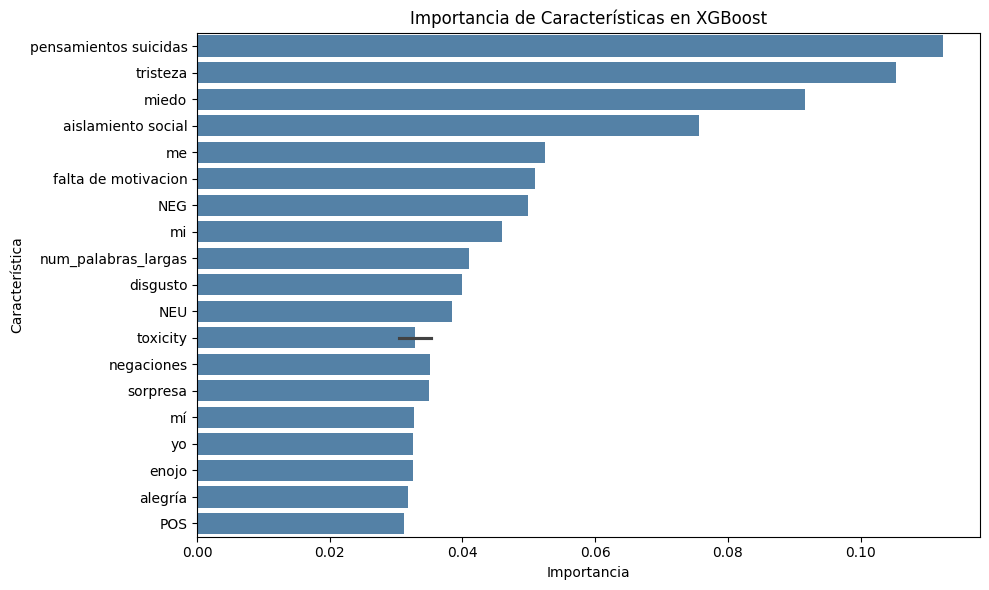

In [ ]:
# ===============================================
# 10. Importancia de características acumulada
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import numpy as np # Import numpy for .values conversion

# Ensure X and y are available from previous steps
if 'X' not in locals() or 'y' not in locals():
     print("Error: X or y is not defined. Please run the data loading and splitting cells first.")
else:
    # Define and train the model with the best parameters
    # Using parameters from the cross-validation step (cell dH0p614FjFjo)
    xgb_model = xgb.XGBClassifier(
        colsample_bytree= 0.8,
        learning_rate =0.01,
        max_depth= 7,
        n_estimators=500,
        subsample= 0.7,
        objective='multi:softmax',
        num_class=3,
        random_state=42
    )

    # Train the model
    # Convert X and y to numpy arrays for fitting
    xgb_model.fit(X.values, y)

    # Calculate feature importances
    try:
        importances = xgb_model.feature_importances_
    except xgb.core.XGBoostError as e:
        print(f"Error getting feature importances: {e}")
        print("This might happen if the model was not trained successfully.")
        importances = None


    if importances is not None and len(importances) == X.shape[1]:
        # Create a DataFrame to order the characteristics
        # Ensure X is a pandas DataFrame or use feature names from X if it's a DataFrame
        if isinstance(X, pd.DataFrame):
             feature_names = X.columns.tolist()
        else:
             feature_names = [f'Feature_{i}' for i in range(X.shape[1])]


        feature_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("Feature Importances:")
        print(feature_importances)

        # Configurar el estilo del gráfico
        plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
        sns.barplot(x='Importance', y='Feature', data=feature_importances, color='steelblue')

        # Agregar etiquetas y título
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.title('Importancia de Características en XGBoost')

        # Mostrar el gráfico
        plt.tight_layout()
        plt.show()
    elif importances is not None:
         print(f"Error: Mismatch between number of features ({X.shape[1]}) and importances ({len(importances)}).")
    else:
        print("Feature importances could not be calculated.")